![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Handling Data Imbalance with Transfer Learning

<img src='images/data_imbalance_histogram.png' alt='Histogram of the data imbalance in the bees vs wasp dataset showing that there are many more images of wasps than other categories.' align='right'>

Welcome to an advanced exploration of handling data imbalance! This notebook combines the power of [**transfer learning**](01.3_transfer_learning.ipynb) with **imbalance handling techniques** to tackle one of the most common challenges in real-world computer vision.

In this notebook, we'll:
1. Work with the **full** bee vs wasp dataset (highly imbalanced)
2. Use **EfficientNetB0** pre-trained features for better performance (We'll use the smaller B0 model here to help speed training along)
3. Apply multiple imbalance handling techniques with transfer learning
5. Evaluate comprehensive metrics appropriate for imbalanced datasets

### Why Transfer Learning + Imbalance Handling?

Transfer learning is particularly powerful for imbalanced datasets because:
- **Pre-trained features**: Rich representations learned from millions of images help even with limited minority class data
- **Faster convergence**: Models train faster, allowing more experimentation with imbalance techniques
- **Better generalization**: Pre-trained features often generalize better to minority classes
- **Reduced overfitting**: Especially important when some classes have very few examples

### The Challenge: Real-World Data Imbalance

Real datasets are messy! The full bee vs wasp dataset contains:
- **Thousands** of images for some classes
- **Hundreds** for others
- Natural distribution that reflects real-world collection challenges

This creates the perfect testbed for combining advanced model architectures with imbalance handling.

### The Lazy Student

One way people explain data imbalance is using an analogy to a lazy student. Imagine that a professor makes a multiple choice test, and a student has figured out that the professor uses "C" as the correct answer 95% of the time. Why study for the test? The student can get a 95% just by answering "C" for all questions. 

Similarly, with unbalanced data, the model can look like it's performing well--scoring a 95% accuracy for example--when in reality, it simply classifies every input as belonging to a class that represents 95% of the overall data. 

## 1. Import Libraries and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# For transfer learning
try:
    import timm
    print(f"timm version: {timm.__version__}")
except ImportError:
    print("Warning: timm not available. Transfer learning features will not work.")
    timm = None

# Import our helper functions
import helpers_01

# Set seed for reproducibility
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

[rank: 0] Seed set to 42


timm version: 1.0.19
PyTorch version: 2.8.0+cu128
PyTorch Lightning version: 2.5.3
CUDA available: True
GPU: NVIDIA L4


## 2. Set Number of Workers for Data Loading

In [2]:
# Set the number of workers to use for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

Using 8 workers for data loading.


## 3. Load the Full (Imbalanced) Dataset

Now we'll load the **full** bee vs wasp dataset with **higher resolution images** (224x224) suitable for EfficientNetB5. This gives us both the class imbalance challenge and the higher quality inputs that transfer learning models expect.

### <img src='images/note_icon.svg' width=40, align='center' alt='Note icon'> Note
> Now that we are using a much larger dataset, the training steps in this notebook will be significantly slower
> than in the previous notebooks.

In [3]:
# Get the full dataset (not the subsampled version)
full_data_path = helpers_01.manage_full_data(
    folder_name="bee_vs_wasp",
)

Found data at: /blue/practicum-ai/share/data/bee_vs_wasp


## 4. Explore the Class Imbalance with Transfer Learning Data

We'll use **224x224 images** (EfficientNetB5's expected input size) and explore the class distribution. The higher resolution will help the pre-trained model extract better features.

In [ ]:
# Load data with higher resolution for transfer learning
# Note: Using 224x224 images as expected by EfficientNetB0

# Reduce num_workers for faster setup (especially on HPC systems)
optimized_num_workers = min(4, num_workers) if num_workers else 4
print(f"Using {optimized_num_workers} workers instead of {num_workers} for faster data loading setup")

# The helpers_01.load_imbalanced_data function has been optimized for better performance
data_module_unbalanced = helpers_01.load_imbalanced_data(
    full_data_path,
    batch_size=16,  # Smaller batch size due to larger images and model
    shape=(224, 224, 3),  # EfficientNetB0 standard input size
    show_pictures=False,  # No need to show pictures here
    train_split=0.8,
    num_workers=optimized_num_workers,  # Use reduced workers for faster setup
    use_weighted_sampler=False,  # No weighted sampling to see natural distribution
)

Using 4 workers instead of 8 for faster data loading setup
******************************************************************
Load imbalanced data (OPTIMIZED VERSION):
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 16.
  - Resizing input images to: (224, 224, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 4 workers for data loading
  - Using weighted sampler: False
******************************************************************
Setting up data module (optimized version)...
Counting class distribution from filesystem...
Data module setup complete!

Class distribution in the full dataset:
   Class                # of images     % of total
--------------------------------------------------------
   bee                 3183       27.9%
   other_insect        2439       21.4%
   other_noinsect       856        7.5%
   wasp                4943       43.3%
--------------------------------------------------------
   Total          

The imbalance is pronounced with the full dataset! 

If we used a smaller CNN model, like in notebook [01.1_bees_vs_wasps](01.1_bees_vs_wasps.ipynb), the imbalance issue would be even more pronounced. Transfer learning alone already helps solve some of the problems by making use of the pre-learned features from a completely different dataset. But as we'll see, more can be done to improve the situation. But realize that without transfer learning, the methods discussed below are even more important!

## 5. Baseline: EfficientNetB0 Feature Extraction (No Imbalance Handling)

Let's start with **feature extraction** - freezing the EfficientNetB0 backbone and only training a new classifier head on the imbalanced data.

TRAINING EFFICIENTNETB5 FEATURE EXTRACTION (No Imbalance Handling)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precis

Backbone (efficientnet_b0) frozen for feature extraction
Model created with 4,665,472 total parameters
Trainable parameters: 657,924
Setting up data module (optimized version)...
Setting up data module (optimized version)...
Counting class distribution from filesystem...
Counting class distribution from filesystem...


/blue/practicum-ai/share/conda/computer_vision/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:701: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | backbone       | EfficientNet       | 4.0 M  | train
1 | global_pool    | AdaptiveAvgPool2d  | 0      | train
2 | flatten        | Flatten            | 0      | train
3 | classifier     | Sequential         | 657 K  | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
5 | val_accuracy   | MulticlassAccuracy | 0      | train
6 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
657 K     Trainable params
4.0 M     Non-trainable params
4.7 M     Total params
18.662    Total estimated model params size (MB)
348      

Data module setup complete!


SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |                                  | 0/? [00:00<?, ?it/s]

Training: |                                         | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.



Baseline Transfer Learning Model Results:
Setting up data module (optimized version)...
Counting class distribution from filesystem...
Counting class distribution from filesystem...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Data module setup complete!


SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |                                          | 0/? [00:00<?, ?it/s]

───────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────────────────────
        test_acc            0.9234135746955872
        test_loss           0.22714360058307648
───────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 8 points
Processing tag: val_acc
Found val acc: val_acc with 8 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 8 points
Processing tag: train_acc
Found train acc: train_acc with 8 points
Processing tag: test_loss
Processing tag: test_acc


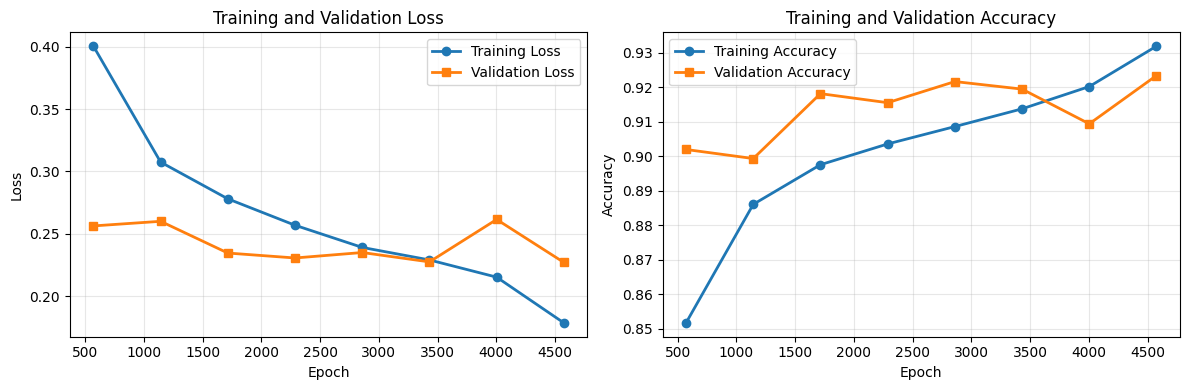

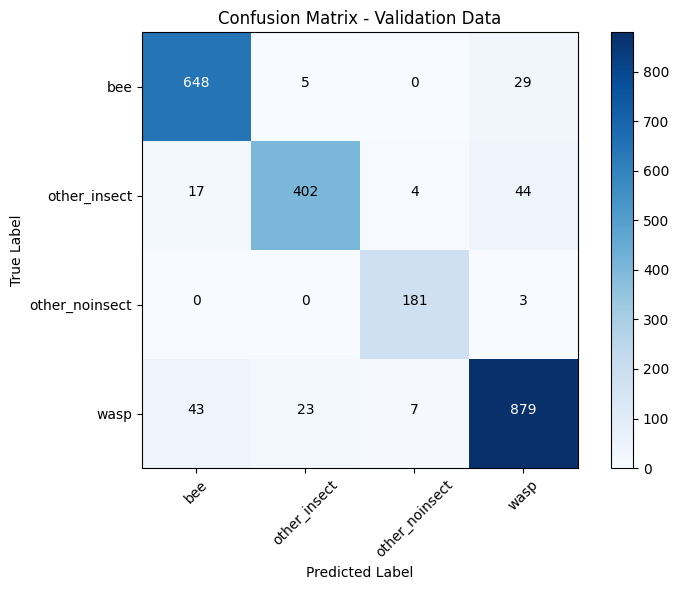


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.915, Recall=0.950, F1=0.932
   other_insect: Precision=0.935, Recall=0.861, F1=0.896
 other_noinsect: Precision=0.943, Recall=0.984, F1=0.963
           wasp: Precision=0.920, Recall=0.923, F1=0.922


In [6]:
print("=" * 60)
print("TRAINING EFFICIENTNETB5 FEATURE EXTRACTION (No Imbalance Handling)")
print("=" * 60)

# Train baseline transfer learning model without imbalance handling
baseline_transfer_model, baseline_transfer_trainer = helpers_01.train_transfer_model(
    data_module=data_module_unbalanced,
    num_classes=4,
    learning_rate=0.001,  # Higher learning rate for new classifier head
    max_epochs=8,  # Faster convergence with transfer learning
    accelerator="auto",
    devices="auto",
    model_name="efficientnet_b0",
    freeze_backbone=True,  # Feature extraction mode
    dropout_rate=0.3,
)

print("\nBaseline Transfer Learning Model Results:")
baseline_transfer_results = helpers_01.test_model(
    data_module_unbalanced, baseline_transfer_model, baseline_transfer_trainer
)

## 6. EfficientNetB0 with Weighted Random Sampling

Now let's apply **weighted random sampling** to the transfer learning approach. This will oversample minority classes while leveraging powerful pre-trained features.

In [ ]:
# Load data WITH weighted sampling for transfer learning
data_module_weighted = helpers_01.load_imbalanced_data(
    full_data_path,
    batch_size=16,  # Consistent with baseline
    shape=(224, 224, 3),  # EfficientNetB0 input size
    show_pictures=False,  # No need to show pictures again
    train_split=0.8,
    num_workers=optimized_num_workers,  # Use the same optimized worker count
    use_weighted_sampler=True,  # Enable weighted sampling
    show_class_distribution=False,  # Don't show distribution again
)

******************************************************************
Load imbalanced data (OPTIMIZED VERSION):
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 16.
  - Resizing input images to: (224, 224, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 4 workers for data loading
  - Using weighted sampler: True
******************************************************************
Setting up data module (optimized version)...
Counting class distribution from filesystem...
Counting class distribution from filesystem...
Calculating sample weights for balanced sampling...
Calculating sample weights for balanced sampling...
Data module setup complete!
Data module setup complete!


TRAINING EFFICIENTNETB0 WITH WEIGHTED SAMPLING
Backbone (efficientnet_b0) frozen for feature extraction
Backbone (efficientnet_b0) frozen for feature extraction


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model created with 4,665,472 total parameters
Trainable parameters: 657,924
Setting up data module (optimized version)...


/blue/practicum-ai/share/conda/computer_vision/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:701: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Counting class distribution from filesystem...
Calculating sample weights for balanced sampling...
Data module setup complete!



  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | backbone       | EfficientNet       | 4.0 M  | train
1 | global_pool    | AdaptiveAvgPool2d  | 0      | train
2 | flatten        | Flatten            | 0      | train
3 | classifier     | Sequential         | 657 K  | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
5 | val_accuracy   | MulticlassAccuracy | 0      | train
6 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
657 K     Trainable params
4.0 M     Non-trainable params
4.7 M     Total params
18.662    Total estimated model params size (MB)
348       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |                                  | 0/? [00:00<?, ?it/s]

Training: |                                         | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.



Weighted Sampling Transfer Learning Model Results:
Setting up data module (optimized version)...
Counting class distribution from filesystem...
Counting class distribution from filesystem...
Calculating sample weights for balanced sampling...
Calculating sample weights for balanced sampling...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.
SLURM auto-requeueing enabled. Setting signal handlers.


Data module setup complete!


Testing: |                                          | 0/? [00:00<?, ?it/s]

───────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────────────────────
        test_acc             0.918161928653717
        test_loss           0.23757989704608917
───────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 8 points
Processing tag: val_acc
Found val acc: val_acc with 8 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 8 points
Processing tag: train_acc
Found train acc: train_acc with 8 points
Processing tag: test_loss
Processing tag: test_acc


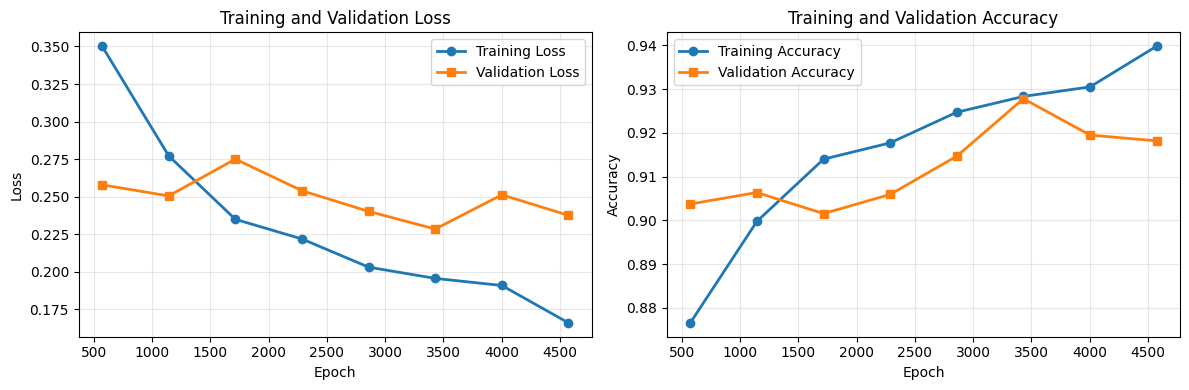

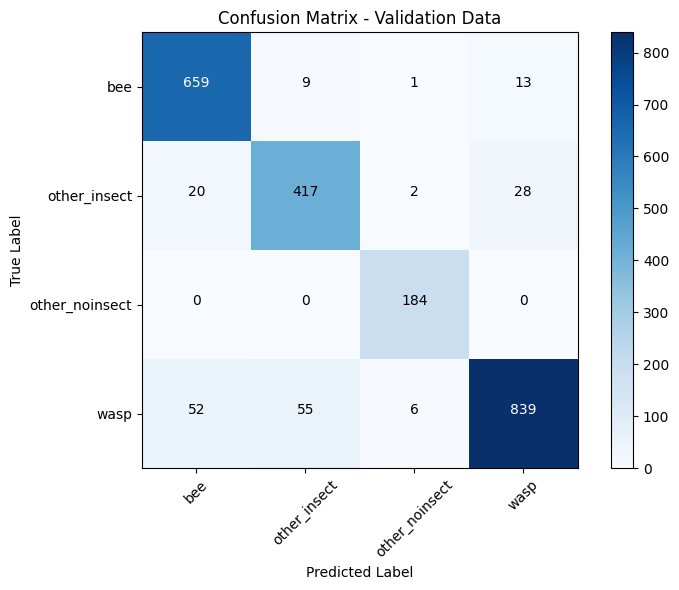


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.902, Recall=0.966, F1=0.933
   other_insect: Precision=0.867, Recall=0.893, F1=0.880
 other_noinsect: Precision=0.953, Recall=1.000, F1=0.976
           wasp: Precision=0.953, Recall=0.881, F1=0.916


In [9]:
print("=" * 60)
print("TRAINING EFFICIENTNETB0 WITH WEIGHTED SAMPLING")
print("=" * 60)

# Train transfer learning model with weighted sampling
weighted_transfer_model, weighted_transfer_trainer = helpers_01.train_transfer_model(
    data_module=data_module_weighted,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=8,
    accelerator="auto",
    devices="auto",
    model_name="efficientnet_b0",
    freeze_backbone=True,  # Feature extraction mode
    dropout_rate=0.3,
)

print("\nWeighted Sampling Transfer Learning Model Results:")
weighted_transfer_results = helpers_01.test_model(
    data_module_weighted, weighted_transfer_model, weighted_transfer_trainer
)

## 7. EfficientNetB0 with Weighted Loss Function

So far, we have looked at not addressing the imbalance, and using weighted sampling. Next, let's create a **weighted loss version** of our transfer learning model. This applies higher penalties for minority class misclassifications while keeping the pre-trained feature power.

Going back to the lazy student analogy from the introduction, weighted loss is like making the penalty for getting a wrong answer on rare questions much higher than for common questions. This forces the "student" (our model) to actually study the rare cases instead of just guessing the most common answer all the time.

In [10]:
# Create a transfer learning model with weighted loss function
class WeightedLossTransferCNN(helpers_01.TransferLearningCNN):
    """Transfer learning model with weighted loss function for handling class imbalance"""

    def __init__(
        self,
        num_classes=4,
        learning_rate=0.001,
        model_name="efficientnet_b0",
        freeze_backbone=True,
        dropout_rate=0.3,
        class_weights=None,
    ):
        super().__init__(
            num_classes=num_classes,
            learning_rate=learning_rate,
            model_name=model_name,
            freeze_backbone=freeze_backbone,
            dropout_rate=dropout_rate,
        )

        # Store class weights for loss function
        if class_weights is not None:
            self.register_buffer("class_weights", class_weights)
        else:
            self.class_weights = None

    def training_step(self, batch, _batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        # Use weighted loss if class weights are provided
        if self.class_weights is not None:
            loss = F.cross_entropy(outputs, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(outputs, labels)

        # Update and log metrics
        self.train_accuracy(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log(
            "train_acc",
            self.train_accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )

        return loss


# Calculate class weights based on inverse frequency
# Access the already-calculated class information to avoid duplicate setup
if hasattr(data_module_unbalanced, 'class_names') and hasattr(data_module_unbalanced, 'class_counts'):
    class_names = data_module_unbalanced.class_names
    class_counts = data_module_unbalanced.class_counts
else:
    # Fallback: get class info (this might trigger the duplicate print)
    class_names, class_counts = data_module_unbalanced.get_class_info()

total_samples = sum(class_counts.values())
num_classes = len(class_names)

class_weights = []
for class_name in class_names:
    weight = total_samples / (num_classes * class_counts[class_name])
    class_weights.append(weight)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(f"Calculated class weights: {class_weights_tensor}")
print("These weights will penalize errors on minority classes more heavily")

Calculated class weights: tensor([0.8970, 1.1707, 3.3356, 0.5776])
These weights will penalize errors on minority classes more heavily


TRAINING EFFICIENTNETB0 WITH WEIGHTED LOSS FUNCTION


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Backbone (efficientnet_b0) frozen for feature extraction
Model created with 4,665,472 total parameters
Trainable parameters: 657,924
Setting up data module (optimized version)...
Counting class distribution from filesystem...
Counting class distribution from filesystem...


/blue/practicum-ai/share/conda/computer_vision/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:701: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | backbone       | EfficientNet       | 4.0 M  | train
1 | global_pool    | AdaptiveAvgPool2d  | 0      | train
2 | flatten        | Flatten            | 0      | train
3 | classifier     | Sequential         | 657 K  | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
5 | val_accuracy   | MulticlassAccuracy | 0      | train
6 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
657 K     Trainable params
4.0 M     Non-trainable params
4.7 M     Total params
18.662    Total estimated model params size (MB)
348      

Data module setup complete!


SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |                                  | 0/? [00:00<?, ?it/s]

Training: |                                         | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

Validation: |                                       | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.



Weighted Loss Transfer Learning Model Results:
Setting up data module (optimized version)...
Counting class distribution from filesystem...
Counting class distribution from filesystem...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Data module setup complete!


SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |                                          | 0/? [00:00<?, ?it/s]

───────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────────────────────
        test_acc            0.9111597537994385
        test_loss           0.2609094977378845
───────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 8 points
Processing tag: val_acc
Found val acc: val_acc with 8 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 8 points
Processing tag: train_acc
Found train acc: train_acc with 8 points
Processing tag: test_loss
Processing tag: test_acc


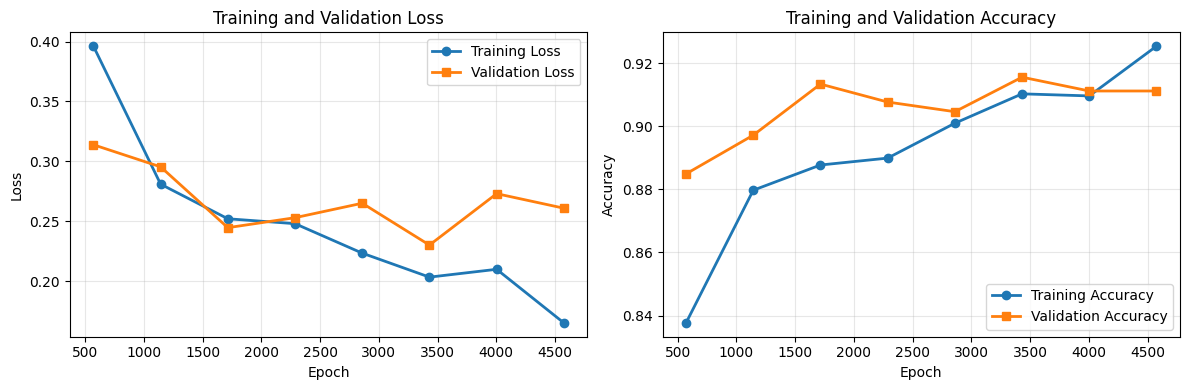

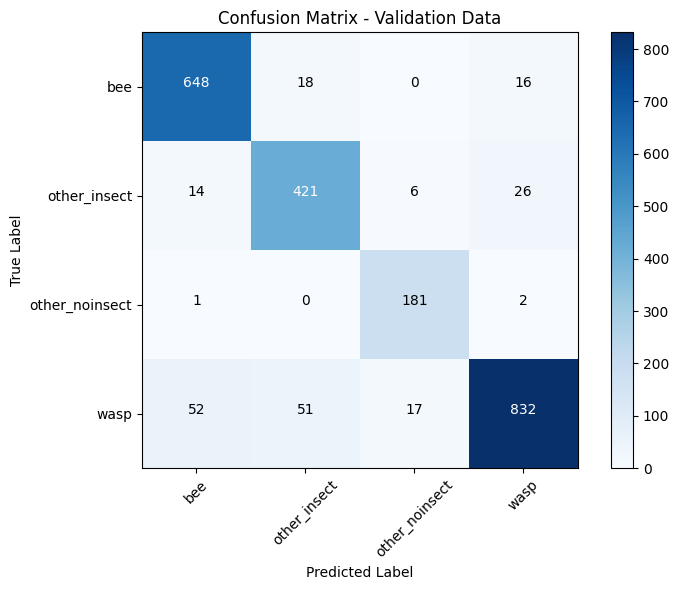


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.906, Recall=0.950, F1=0.928
   other_insect: Precision=0.859, Recall=0.901, F1=0.880
 other_noinsect: Precision=0.887, Recall=0.984, F1=0.933
           wasp: Precision=0.950, Recall=0.874, F1=0.910


In [11]:
print("=" * 60)
print("TRAINING EFFICIENTNETB0 WITH WEIGHTED LOSS FUNCTION")
print("=" * 60)

# Create transfer learning model with weighted loss
weighted_loss_transfer_model = WeightedLossTransferCNN(
    num_classes=4,
    learning_rate=0.001,
    model_name="efficientnet_b0",
    freeze_backbone=True,  # Feature extraction mode
    dropout_rate=0.3,
    class_weights=class_weights_tensor,
)

# Create trainer for weighted loss model
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

logger = TensorBoardLogger("lightning_logs", name="weighted_loss_transfer_experiment")

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, verbose=False, mode="min"
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath="checkpoints/",
    filename="weighted-loss-transfer-best-checkpoint",
    save_top_k=1,
    mode="max",
)

weighted_loss_transfer_trainer = pl.Trainer(
    max_epochs=8,
    accelerator="auto",
    devices="auto",
    logger=logger,
    callbacks=[early_stopping, checkpoint_callback],
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Train the model (use unbalanced data module since we're handling imbalance in the loss function)
weighted_loss_transfer_trainer.fit(weighted_loss_transfer_model, datamodule=data_module_unbalanced)

print("\nWeighted Loss Transfer Learning Model Results:")
weighted_loss_transfer_results = helpers_01.test_model(
    data_module_unbalanced, weighted_loss_transfer_model, weighted_loss_transfer_trainer
)

## 9. Detailed Evaluation and Comparison

Let's create a comprehensive comparison of all transfer learning approaches using detailed metrics appropriate for imbalanced datasets.


COMPREHENSIVE TRANSFER LEARNING MODEL COMPARISON

EfficientNetB0 Baseline (Feature Extraction) - Detailed Evaluation:

EfficientNetB0 Baseline (Feature Extraction) - Detailed Evaluation:
Classification Report:
                precision    recall  f1-score   support

           bee      0.915     0.950     0.932       682
  other_insect      0.935     0.861     0.896       467
other_noinsect      0.943     0.984     0.963       184
          wasp      0.920     0.923     0.922       952

      accuracy                          0.923      2285
     macro avg      0.928     0.929     0.928      2285
  weighted avg      0.924     0.923     0.923      2285

Classification Report:
                precision    recall  f1-score   support

           bee      0.915     0.950     0.932       682
  other_insect      0.935     0.861     0.896       467
other_noinsect      0.943     0.984     0.963       184
          wasp      0.920     0.923     0.922       952

      accuracy                   

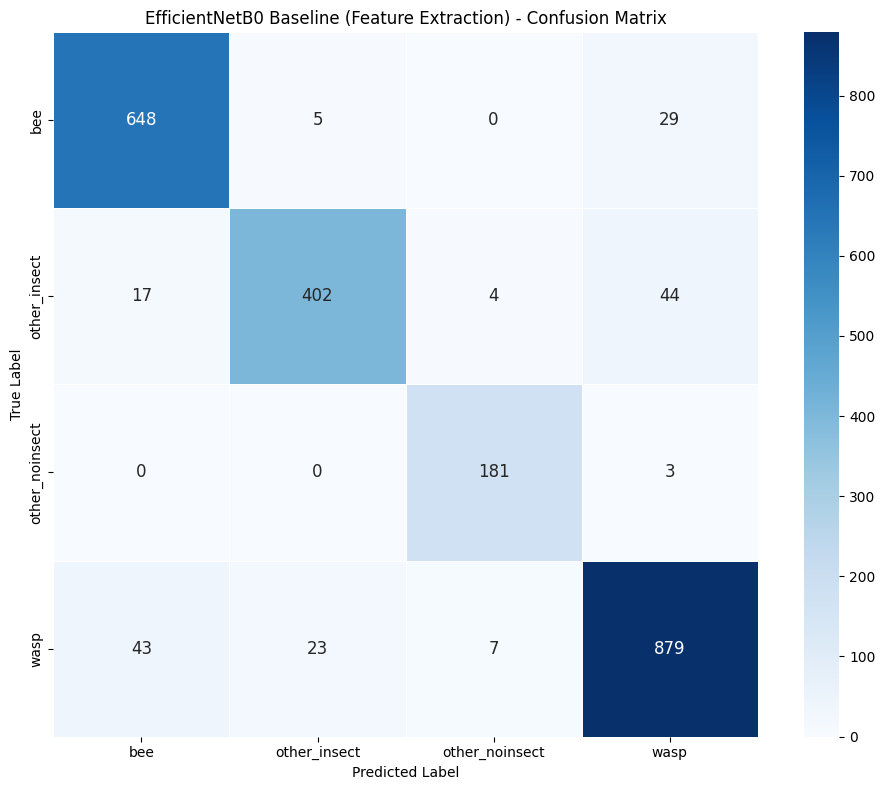


Per-class Accuracy:
  bee: 0.950
  other_insect: 0.861
  other_noinsect: 0.984
  wasp: 0.923

Prediction Confidence by Class:
  bee: 0.920 (avg confidence when correctly predicted)
  other_insect: 0.842 (avg confidence when correctly predicted)
  other_noinsect: 0.972 (avg confidence when correctly predicted)
  wasp: 0.884 (avg confidence when correctly predicted)

EfficientNetB0 + Weighted Sampling - Detailed Evaluation:
Classification Report:
                precision    recall  f1-score   support

           bee      0.902     0.966     0.933       682
  other_insect      0.867     0.893     0.880       467
other_noinsect      0.953     1.000     0.976       184
          wasp      0.953     0.881     0.916       952

      accuracy                          0.919      2285
     macro avg      0.919     0.935     0.926      2285
  weighted avg      0.920     0.919     0.918      2285


EfficientNetB0 + Weighted Sampling - Detailed Evaluation:
Classification Report:
                p

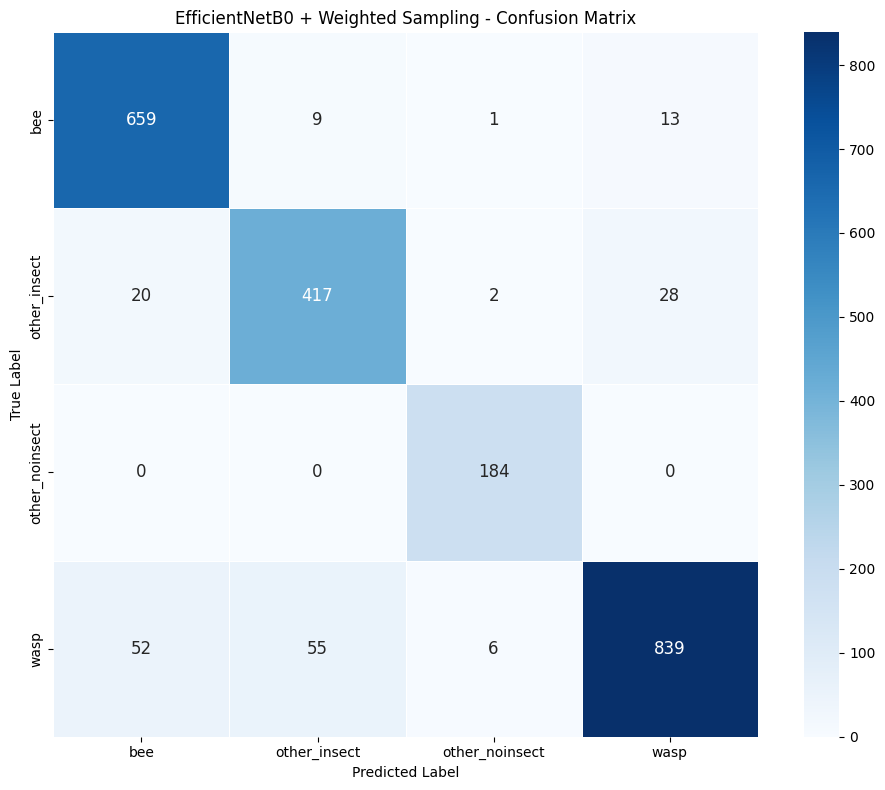


Per-class Accuracy:
  bee: 0.966
  other_insect: 0.893
  other_noinsect: 1.000
  wasp: 0.881

Prediction Confidence by Class:
  bee: 0.936 (avg confidence when correctly predicted)
  other_insect: 0.877 (avg confidence when correctly predicted)
  other_noinsect: 0.982 (avg confidence when correctly predicted)
  wasp: 0.848 (avg confidence when correctly predicted)

EfficientNetB0 + Weighted Loss - Detailed Evaluation:
Classification Report:
                precision    recall  f1-score   support

           bee      0.906     0.950     0.928       682
  other_insect      0.859     0.901     0.880       467
other_noinsect      0.887     0.984     0.933       184
          wasp      0.950     0.874     0.910       952

      accuracy                          0.911      2285
     macro avg      0.901     0.927     0.913      2285
  weighted avg      0.913     0.911     0.911      2285


EfficientNetB0 + Weighted Loss - Detailed Evaluation:
Classification Report:
                precision

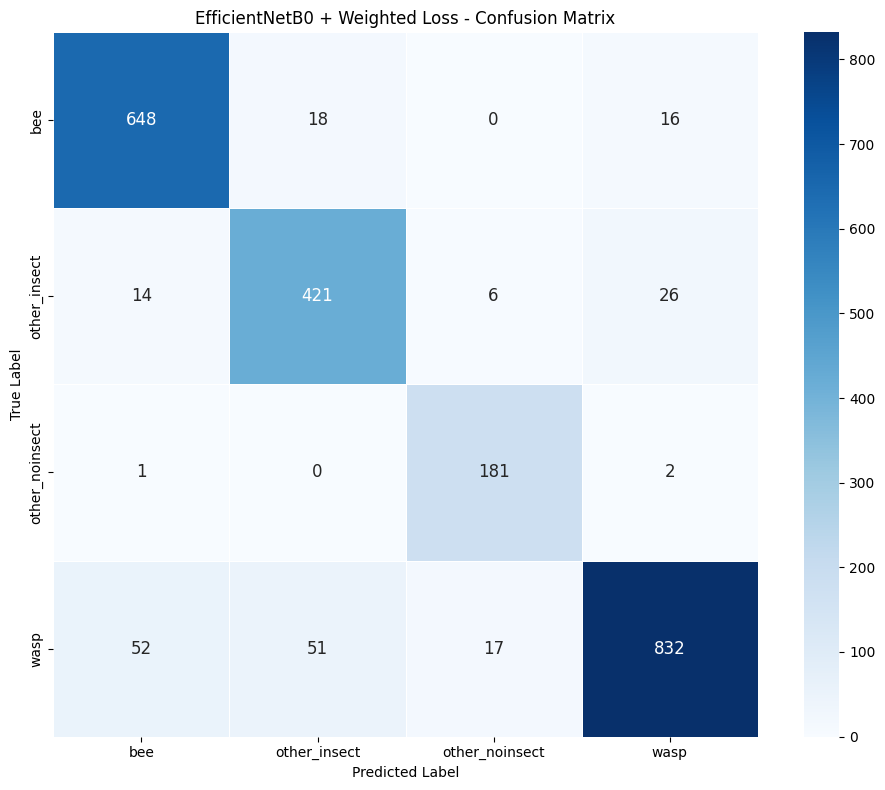


Per-class Accuracy:
  bee: 0.950
  other_insect: 0.901
  other_noinsect: 0.984
  wasp: 0.874

Prediction Confidence by Class:
  bee: 0.917 (avg confidence when correctly predicted)
  other_insect: 0.885 (avg confidence when correctly predicted)
  other_noinsect: 0.983 (avg confidence when correctly predicted)
  wasp: 0.832 (avg confidence when correctly predicted)


In [12]:
def detailed_evaluation_transfer(model, data_module, trainer, model_name):
    """Perform detailed evaluation with metrics appropriate for imbalanced datasets"""

    # Get predictions on validation set
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    val_loader = data_module.val_dataloader()
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    # Get class names
    class_names, _ = data_module.get_class_info()

    print(f"\n{model_name} - Detailed Evaluation:")
    print("=" * 60)

    # Classification report
    report = classification_report(
        all_labels, all_preds, target_names=class_names, digits=3, zero_division=0
    )
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True,
        square=True,
        linewidths=0.5,
        annot_kws={"size": 12},
    )
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    # Calculate per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {per_class_acc[i]:.3f}")

    # Calculate confidence statistics for each class
    print(f"\nPrediction Confidence by Class:")
    for i, class_name in enumerate(class_names):
        class_probs = [all_probs[j][i] for j in range(len(all_probs)) if all_labels[j] == i]
        if class_probs:
            avg_conf = np.mean(class_probs)
            print(f"  {class_name}: {avg_conf:.3f} (avg confidence when correctly predicted)")

    return {
        "predictions": all_preds,
        "labels": all_labels,
        "probabilities": all_probs,
        "confusion_matrix": cm,
        "per_class_accuracy": per_class_acc,
    }


# Evaluate all transfer learning models
print("\n" + "=" * 80)
print("COMPREHENSIVE TRANSFER LEARNING MODEL COMPARISON")
print("=" * 80)

baseline_transfer_eval = detailed_evaluation_transfer(
    baseline_transfer_model,
    data_module_unbalanced,
    baseline_transfer_trainer,
    "EfficientNetB0 Baseline (Feature Extraction)",
)

weighted_transfer_eval = detailed_evaluation_transfer(
    weighted_transfer_model, 
    data_module_weighted, 
    weighted_transfer_trainer, 
    "EfficientNetB0 + Weighted Sampling"
)

weighted_loss_transfer_eval = detailed_evaluation_transfer(
    weighted_loss_transfer_model,
    data_module_unbalanced,
    weighted_loss_transfer_trainer,
    "EfficientNetB0 + Weighted Loss",
)



## 10. Comprehensive Summary and Analysis

In [13]:
# Create comprehensive summary comparison
class_names, class_counts = data_module_unbalanced.get_class_info()

print("\n" + "=" * 90)
print("TRANSFER LEARNING + IMBALANCE HANDLING - SUMMARY COMPARISON")
print("=" * 90)

print("\nPer-Class Accuracy Comparison:")
print(f"{'Class':<15} {'Baseline':<12} {'+ Weighted':<12} {'+ W.Loss':<12} ")
print("-" * 55)

for i, class_name in enumerate(class_names):
    baseline_acc = baseline_transfer_eval["per_class_accuracy"][i]
    weighted_acc = weighted_transfer_eval["per_class_accuracy"][i]
    weighted_loss_acc = weighted_loss_transfer_eval["per_class_accuracy"][i]


    print(
        f"{class_name:<15} {baseline_acc:<12.3f} {weighted_acc:<12.3f} {weighted_loss_acc:<12.3f} "
    )

# Calculate comprehensive metrics
print(f"\n{'Metric':<25} {'Baseline':<12} {'+ Weighted':<12} {'+ W.Loss':<12} ")
print("-" * 65)

# Macro average (unweighted mean of per-class accuracies)
baseline_macro = np.mean(baseline_transfer_eval["per_class_accuracy"])
weighted_macro = np.mean(weighted_transfer_eval["per_class_accuracy"])
weighted_loss_macro = np.mean(weighted_loss_transfer_eval["per_class_accuracy"])


print(
    f"{'Macro Avg Accuracy':<25} {baseline_macro:<12.3f} {weighted_macro:<12.3f} {weighted_loss_macro:<12.3f} "
)

# Overall accuracy
baseline_overall = np.sum(np.diag(baseline_transfer_eval["confusion_matrix"])) / np.sum(
    baseline_transfer_eval["confusion_matrix"]
)
weighted_overall = np.sum(np.diag(weighted_transfer_eval["confusion_matrix"])) / np.sum(
    weighted_transfer_eval["confusion_matrix"]
)
weighted_loss_overall = np.sum(
    np.diag(weighted_loss_transfer_eval["confusion_matrix"])
) / np.sum(weighted_loss_transfer_eval["confusion_matrix"])


print(
    f"{'Overall Accuracy':<25} {baseline_overall:<12.3f} {weighted_overall:<12.3f} {weighted_loss_overall:<12.3f}"
)

# Display class distribution for context
print(f"\n{'Class Distribution:'}")
print("-" * 50)
for class_name in class_names:
    count = class_counts[class_name]
    percentage = (count / sum(class_counts.values())) * 100
    print(f"  {class_name}: {count:,} images ({percentage:.1f}%)")


TRANSFER LEARNING + IMBALANCE HANDLING - SUMMARY COMPARISON

Per-Class Accuracy Comparison:
Class           Baseline     + Weighted   + W.Loss     
-------------------------------------------------------
bee             0.950        0.966        0.950        
other_insect    0.861        0.893        0.901        
other_noinsect  0.984        1.000        0.984        
wasp            0.923        0.881        0.874        

Metric                    Baseline     + Weighted   + W.Loss     
-----------------------------------------------------------------
Macro Avg Accuracy        0.929        0.935        0.927        
Overall Accuracy          0.923        0.919        0.911       

Class Distribution:
--------------------------------------------------
  bee: 3,183 images (27.9%)
  other_insect: 2,439 images (21.4%)
  other_noinsect: 856 images (7.5%)
  wasp: 4,943 images (43.3%)


## 11. Key Insights: Transfer Learning + Imbalance Handling

Based on our comprehensive experiments, here are the key insights when combining transfer learning with imbalance handling:

### 🎯 **Transfer Learning Advantages for Imbalanced Data:**

1. **Rich Feature Representations**: EfficientNetB0's pre-trained features help even minority classes by providing sophisticated visual understanding
2. **Faster Convergence**: Models reach good performance in fewer epochs, allowing more experimentation with imbalance techniques
3. **Better Generalization**: Pre-trained features often capture patterns that help minority classes generalize better
4. **Reduced Overfitting**: Especially critical when some classes have very few examples

### 📊 **Technique Performance Comparison:**

1. **Feature Extraction Baseline**: 
   - Good starting point with pre-trained features
   - May still be biased toward majority classes
   - Fast training, lower computational cost

2. **Weighted Random Sampling**:
   - Excellent for improving minority class performance
   - Works particularly well with transfer learning
   - Ensures balanced exposure during training

3. **Weighted Loss Function**:
   - Good balance between majority and minority performance
   - Maintains original data distribution
   - Computationally efficient


### 🔍 **Best Practices for Transfer Learning + Imbalance:**

1. **Start with Feature Extraction**: Fast baseline to understand the problem
2. **Apply Weighted Sampling**: Usually the most effective imbalance technique with transfer learning
3. **Consider Fine-tuning**: For the best performance when computational resources allow
4. **Monitor Per-Class Metrics**: Focus on macro-averaged metrics and per-class performance
5. **Use Appropriate Input Size**: Match the pre-trained model's expected input (224x224 for EfficientNetB5)

### 🎯 **When to Use Each Approach:**

- **Feature Extraction + Weighted Sampling**: Best balance of performance and speed
- **Fine-tuning + Weighted Sampling**: When you need maximum performance
- **Weighted Loss**: When you want to maintain data distribution but improve minority class performance
- **Combination Approaches**: Advanced users can combine multiple techniques for optimal results

### 💡 **Real-World Applications:**

This combination is particularly powerful for:
- **Medical imaging**: Where rare conditions need accurate detection
- **Quality control**: Where defects are rare but critical to catch
- **Wildlife monitoring**: Where some species are much rarer than others
- **Security applications**: Where threats are infrequent but important to identify

## 12. Advanced Experiments

Try these advanced modifications to further improve performance:

1. **Different Pre-trained Models**: Try EfficientNetB3 (faster) or EfficientNetB7 (more accurate)
2. **Progressive Unfreezing**: Start with frozen backbone, then gradually unfreeze layers
3. **Custom Class Weights**: Experiment with non-linear weighting schemes
4. **Data Augmentation**: Add augmentation specifically for minority classes
5. **Ensemble Methods**: Combine multiple models for better performance

Use the code cells below for your experiments:

In [ ]:
# Advanced experiment cell 1: Try different EfficientNet variants
print("Experiment: Comparing EfficientNet model sizes")

# Example: Try EfficientNetB3 (smaller, faster)
# efficientb3_model, efficientb3_trainer = helpers_01.train_transfer_model(
#     data_module=data_module_weighted,
#     num_classes=4,
#     learning_rate=0.001,
#     max_epochs=5,
#     model_name="efficientnet_b3",
#     freeze_backbone=True,
#     dropout_rate=0.3,
# )

# Compare inference speed and accuracy
print("You can implement model comparison experiments here")

In [ ]:
# Advanced experiment cell 2: Progressive unfreezing
print("Experiment: Progressive unfreezing strategy")

# Example implementation:
# 1. Train with frozen backbone for a few epochs
# 2. Unfreeze top layers and train with lower learning rate
# 3. Gradually unfreeze more layers

print("You can implement progressive unfreezing experiments here")

In [ ]:
# Advanced experiment cell 3: Custom augmentation for minority classes
print("Experiment: Targeted augmentation for minority classes")

# You could create custom data loaders that apply stronger augmentation
# to minority classes while keeping lighter augmentation for majority classes

print("You can implement custom augmentation strategies here")

----
## Push changes to GitHub <img src="images/push_to_github.png" alt="Push to GitHub icon" align="right" width=150>

 Remember to **add**, **commit**, and **push** the changes you have made to this notebook to GitHub to keep your repository in sync.

In Jupyter, those are done in the git tab on the left. In Google Colab, use File > Save a copy in GitHub.